In [1]:
from datasets import load_dataset

wmtis = load_dataset("nlphuji/wmtis-identify")['test']
normal_ims = wmtis['normal_image']
strange_ims = wmtis['strange_image']

/home/petrushina/miniconda3/envs/llm/lib/python3.10/site-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/home/petrushina/miniconda3/envs/llm/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for nlphuji/wmtis-identify contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nlphuji/wmtis-identify
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [2]:
import torch

from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration, AutoTokenizer, AutoModelForSequenceClassification

prompt = """[INST]
List 10 different facts (captions) about this picture. Give the facts only about the content of the image, where one fact describes one feature of the image.
To describe people, objects, and events, use information from Wikipedia for well-known entities.
In cases of ambiguity in the image, describe each part separately.
Include information about objects, subjects, environments, their descriptions, and actions. 
The format of the facts should be: subject predicate addition.
Follow this template:
1.
2.
3.
<image>[/INST]"""

captioning_model = "llava-hf/llava-v1.6-mistral-7b-hf"

llava_processor = LlavaNextProcessor.from_pretrained(captioning_model)
llava_model = LlavaNextForConditionalGeneration.from_pretrained(captioning_model, torch_dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto")

nli_model = 'sileod/deberta-v3-base-tasksource-nli'#, 'MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7'

def aggregate_nli(prediction):
    return prediction['entailment'] - prediction['contradiction']

device = torch.device("cuda")
tokenizer = AutoTokenizer.from_pretrained(nli_model)
model = AutoModelForSequenceClassification.from_pretrained(nli_model).to(device)

label_to_id = {
    'entailment': 1,
    'neutral': 0,
    'contradiction': -1
}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
from tqdm.notebook import tqdm
from runner import process_image

metrics = []

for image in tqdm(normal_ims):
    metric = process_image(image, llava_processor, llava_model, prompt, aggregate_nli, tokenizer, model, device, True, False)
    metrics.append(metric)

  0%|          | 0/102 [00:00<?, ?it/s]

In [7]:
s_metrics = []

for image in tqdm(strange_ims):
    metric = process_image(image, llava_processor, llava_model, prompt, aggregate_nli, tokenizer, model, device, True, False)
    s_metrics.append(metric)

  0%|          | 0/102 [00:00<?, ?it/s]

In [8]:
import numpy as np

with open('strange.npy', 'wb') as f:
    np.save(f, s_metrics)

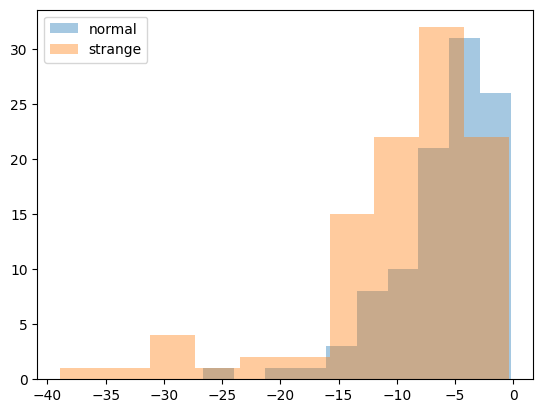

In [12]:
import matplotlib.pyplot as plt

plt.hist(metrics, alpha=0.4, label='normal')
plt.hist(s_metrics, alpha=0.4, label='strange')
plt.legend();

In [21]:
import scipy.stats as sps

sps.kstest(s_metrics, metrics, alternative='greater')

KstestResult(statistic=0.3137254901960784, pvalue=3.8721354649165894e-05, statistic_location=-6.04, statistic_sign=1)

In [17]:
(np.array(metrics) > np.array(s_metrics)).mean()

0.6862745098039216